In [1]:
import matplotlib.pyplot as plt
import os
import json
import cv2
import torch
import copy
import numpy as np

In [2]:
class PLTPoltter():
    def __init__(self, ax_size, **kwargs):
        self.fig, self.ax = plt.subplots(*ax_size, **kwargs)

    def plt_show_cv2_img(self, cv2_img, ax_id):
        self.ax[ax_id].imshow(cv2_img[:, :, ::-1])

    def plt_show_np_single_channel(self, np_array, channel, ax_id):
        array = np_array[channel]
        self.ax[ax_id].imshow(array)

    def plt_show_np_concat(self, np_array, concat_num, ax_id):
        channel, height, wdith = np_array.shape
        concat = np.zeros((height, wdith))
        for c in range(concat_num):
            # print(np.max(np_array[c]))
            concat += np_array[c]
        self.ax[ax_id].imshow(concat)

In [6]:
from dataset import HandPoseDataset

model_input_size = (256, 192)
mdoel_output_size = (64, 48)

data_root = '/home/zg/wdir/zg/moyu/GestureDet/Datasets/train_val_jsons'
hand_pose_dataset = HandPoseDataset(data_root=data_root, split='test', debug_vis=True)


[INFO] generated [1100] samples.


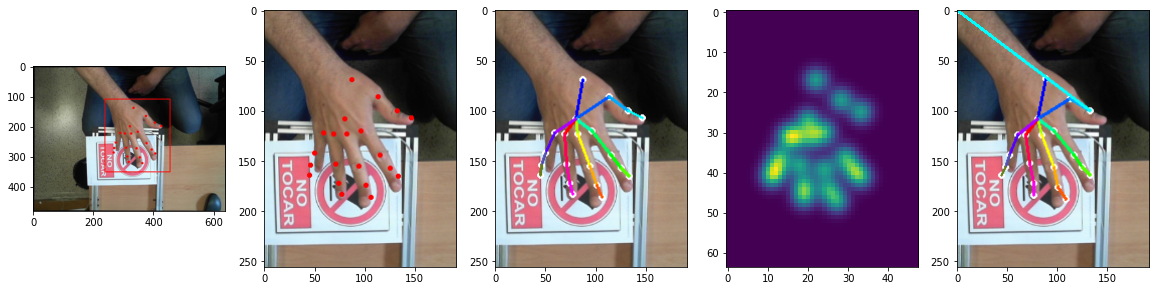

In [13]:
# fetch data
sample_id = 8
dataset_name = hand_pose_dataset.samples[sample_id]['dataset_name']
full_img_path = hand_pose_dataset.samples[sample_id]['image_path']
full_img = cv2.imread(full_img_path)
affined_img, target_mask, target_weight, affined_joints, bbox, joints = hand_pose_dataset.__getitem__(sample_id)

full_img_gt = copy.deepcopy(full_img)
xmin, ymin, xmax, ymax = bbox
full_img_gt = cv2.rectangle(full_img_gt, (xmin, ymin), (xmax, ymax), color=(0, 0, 255), thickness=2)
for pt in joints:
    x, y = pt
    full_img_gt = cv2.circle(full_img_gt, (int(x), int(y)), radius=1, color=(0, 0, 255), thickness=5)

affined_img_joints = copy.deepcopy(affined_img)
for i, pt in enumerate(affined_joints):
    x, y = pt
    affined_img_joints = cv2.circle(affined_img_joints, (int(x), int(y)), radius=1, color=(0, 0, 255), thickness=2)
    # cv2.putText(affined_img_gt, str(i),(int(x),int(y)),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,0,255),1)

# from pose_utils.vis import draw_joint_pair
# affined_img_gt = draw_joint_pair(affined_img_gt, affined_joints)

from pose_utils.vis import draw_result_on_img, draw_result_from_heatmap
pair_format = 'MHP' if dataset_name == 'MHP' else 'common'
affined_img_gt_pair_joints = copy.deepcopy(affined_img)
affined_img_gt_pair_joints = draw_result_on_img(affined_img_gt_pair_joints, affined_joints, format=pair_format)

joint_from_heatmap_img = draw_result_from_heatmap(affined_img, target_mask, feat_stride=4, format=pair_format)

plt_poltter = PLTPoltter(ax_size=(1, 5), figsize=(20, 10))
plt_poltter.plt_show_cv2_img(full_img_gt, 0)   
plt_poltter.plt_show_cv2_img(affined_img_joints, 1) 
plt_poltter.plt_show_cv2_img(affined_img_gt_pair_joints, 2) 
plt_poltter.plt_show_np_concat(target_mask, 21, 3)
plt_poltter.plt_show_cv2_img(joint_from_heatmap_img, 4)

# see_channel = 5
# plt_poltter.plt_show_np_single_channel(pred_mask_numpy, channel=see_channel, ax_id=1)

In [ ]:
from model import UltraLightSimplePoseNet

weight_path = './checkpoints/mobilenetv2_epoch_9_acc1_0.93.pt'
model = UltraLightSimplePoseNet().cuda()
model.load_state_dict(torch.load(weight_path))
model.eval()

In [14]:
from model import UltraLightSimplePoseNet
from pose_utils.transforms import to_tensor, norm

norm_tensor_img = norm(to_tensor(affined_img), (-0.406, -0.457, -0.480))
unsqueeze_norm_tensor_img = norm_tensor_img.unsqueeze(0).cuda()
out_mask = model(unsqueeze_norm_tensor_img)
pred_mask_numpy = out_mask[0].cpu().detach().numpy()

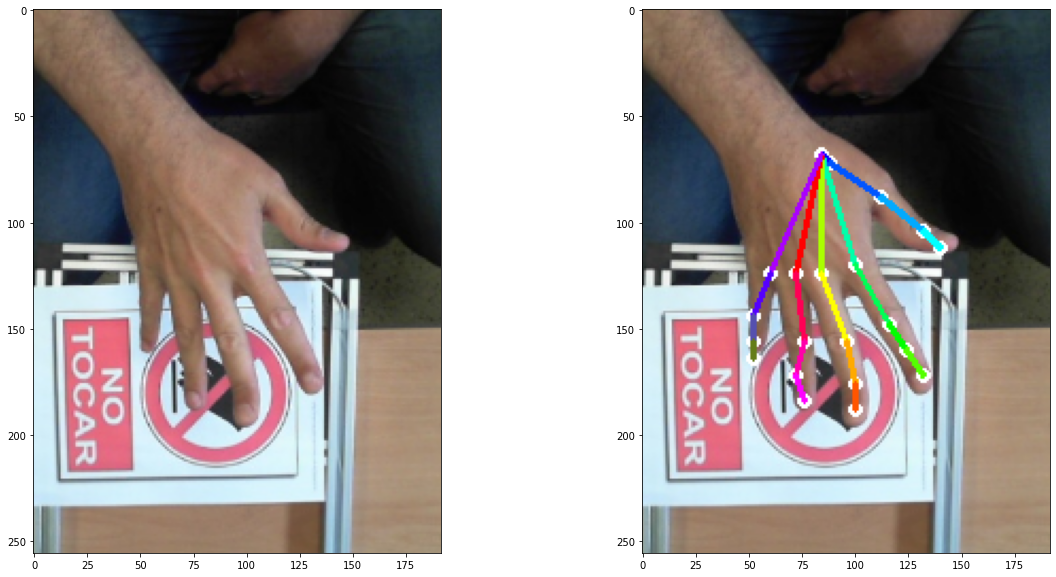

In [15]:
from pose_utils.vis import draw_result_from_heatmap
affined_img_pred = copy.deepcopy(affined_img)
joint_from_heatmap_img = draw_result_from_heatmap(affined_img_pred, pred_mask_numpy, feat_stride=4)

# see mask
plt_poltter = PLTPoltter(ax_size=(1, 2), figsize=(20, 10))
plt_poltter.plt_show_cv2_img(affined_img, 0) 
plt_poltter.plt_show_cv2_img(joint_from_heatmap_img, 1)   
see_channel = 20
# plt_poltter.plt_show_np_single_channel(target_mask, see_channel, 1)
# plt_poltter.plt_show_np_single_channel(pred_mask_numpy, see_channel, 2)
# plt_poltter.plt_show_np_concat(target_mask, 21, 1)
# plt_poltter.plt_show_np_concat(pred_mask_numpy, 21, 2)

In [ ]:
# see joints
from pose_utils.transforms import heatmap_to_coord_simple

preds, maxvals = heatmap_to_coord_simple(pred_mask_numpy, bbox)
pred_recover_joint_img = copy.deepcopy(full_img)
for pt in preds:
    x, y = pt
    pred_recover_joint_img = cv2.circle(pred_recover_joint_img, center=(int(x), int(y)), radius=2, color=(255, 255, 255), thickness=2)

gt_joints, maxvals = heatmap_to_coord_simple(target_mask, bbox)
gt_recover_joint_img = copy.deepcopy(full_img)
for pt in gt_joints:
    x, y = pt
    gt_recover_joint_img = cv2.circle(gt_recover_joint_img, center=(int(x), int(y)), radius=2, color=(255, 255, 255), thickness=2)

plt_poltter = PLTPoltter(ax_size=(1, 2), figsize=(20, 10))
plt_poltter.plt_show_cv2_img(pred_recover_joint_img, 0)   
plt_poltter.plt_show_cv2_img(gt_recover_joint_img, 1) 